### Fist, authenticate to google and import librabies

In [35]:
# ! pip install geemap
# import geemap
import ee
import numpy as np
import pandas as pd
from pprint import pprint
from osgeo import gdal, osr

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import *

import json
import sys
import glob

In [2]:
from google.colab import drive
drive.mount('/content/G_drive')

# cp tokens
!mkdir /root/.config/earthengine/
!cp '/content/G_drive/MyDrive/Colab Notebooks/Google_Earth_Engine_tokes/credentials' /root/.config/earthengine/credentials 

# authenticate earthengine api
ee.Initialize()

# create the tmp folder
! mkdir /content/tf_tmp

Mounted at /content/G_drive


In [ ]:
# Cloud authentication.
from google.colab import auth
auth.authenticate_user()

In [4]:
# import the mask to constrain all data produced within the research region
mask = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_1990_1992/Control_1990_1992_0").mask()
region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

### Preparing the distance-to-road map

In [ ]:
max_dist = 10000
road_avaliable_year = [2013,2016,2019]


# import necessary data
road_shps = [ee.FeatureCollection(f"users/wangjinzhulala/GEE_TF/vector_shp/road_{year}") for year in road_avaliable_year]
dist_to_road_imgs = [f.distance(max_dist) for f in road_shps]

# fill the area exceeding the max_distant with the value of max_distant
dist_img_clamp = []

for img in dist_to_road_imgs:

  out_bound_img = img.mask().remap([0,1],[1,0]).multiply(max_dist)
  img = img.unmask().add(out_bound_img).updateMask(mask)

  dist_img_clamp.append(img)

In [ ]:
# export the distance imgs

for img,year in zip(dist_img_clamp,road_avaliable_year):

  desc = f'Dist_road_{year}'

  # create the task
  task = ee.batch.Export.image.toAsset(
        image = img, 
        description=desc, 
        assetId=f'users/wangjinzhulala/GEE_TF/Distance_imgs/{desc}', 
        region=region.geometry().bounds(), 
        scale=30, 
        maxPixels=int(1e13)
    )

  # start the export
  task.start()

  # report the process
  print(f'Exporting {desc}')

Explore the distance histogram urban pixel to road

In [11]:
# import imgs
dist_img = ee.Image("users/wangjinzhulala/GEE_TF/Distance_imgs/Dist_road_2013").toInt16()
urban_img = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward").gte(3)

In [13]:
# create remap list
remap_from = range(1,10001)
remap_to = map(lambda x: (int(x/100)+1)*10,remap_from)

# create the zonal img
zone_img = dist_img.remap(list(remap_from),list(remap_to)).add(urban_img)

In [15]:
stats = zone_img.reduceRegion(reducer = ee.Reducer.frequencyHistogram(),
                geometry = region.geometry().convexHull(),
                scale = 30,
                maxPixels = int(1e13))

In [18]:
t = stats.getInfo()['remapped']

In [42]:
df = pd.DataFrame({k.zfill(4)[:-1]:[v] for k,v in t.items() if k[-1] == '1' }).T
df = df.sort_index()
df['x'] = range(1,len(df)+1)
df.columns = ['x','y']

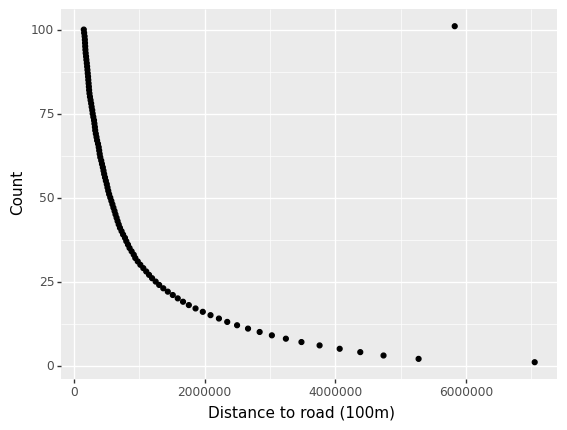

<ggplot: (8782180564825)>

In [45]:
( ggplot(data=df)+
 geom_point(aes('x',y='y'))+
 scale_x_continuous(name='Distance to road (100m)') + 
 scale_y_continuous(name='Count')
)

### Download the projection transtion potential img

In [ ]:
# get the imgs from ee-asset
imgs = ! earthengine ls users/wangjinzhulala/GEE_TF/Urban_projection/
imgs = imgs[3:]

In [ ]:
# set parameters for export
img_folder = 'urban_projection_result_imgs'

In [ ]:
for img in imgs:
  #mosaic img_col to a single img
  img_mosaic = ee.ImageCollection(img).mosaic().toInt16()

  # get the description
  desc  =img.split('/')[-1]

  # initiate the img
  task = ee.batch.Export.image.toDrive(
      image = img_mosaic,
      description = desc,
      folder = img_folder,
      fileNamePrefix = desc,
      region = region.geometry(),
      scale = 30, 
      maxPixels = int(1e13), 
      skipEmptyTiles = True
  )

  # start the export
  task.start()
  # report the process
  print(img)

projects/earthengine-legacy/assets/users/wangjinzhulala/GEE_TF/Urban_projection/FCNN_2011_2013_and_2014_2016_prj_2017_2019_mix_no_years_20
projects/earthengine-legacy/assets/users/wangjinzhulala/GEE_TF/Urban_projection/FCNN_2011_2013_and_2014_2016_prj_2017_2019_mix_years_80
projects/earthengine-legacy/assets/users/wangjinzhulala/GEE_TF/Urban_projection/FCNN_2011_2013_and_2014_2016_prj_2017_2019_no_distance_100
projects/earthengine-legacy/assets/users/wangjinzhulala/GEE_TF/Urban_projection/FCNN_2011_2013_and_2014_2016_prj_2017_2019_with_distance_200
